<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration4_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade statsmodels 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 9.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.2


## 1. 시계열 데이터 준비  
각 주식의 시계열 데이터를 준비합니다.  
저는 평소에 관심이 많은 넥슨과 세계적인 기업 아마존, 자주 이용하고 있는 쿠팡의 데이터를 준비하였습니다.  
각 csv파일을 불러오고 시계열 데이터를 생성하도록 하겠습니다.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

nexon_filepath = '/content/drive/MyDrive/Colab/Datasets/Stock_price/nexon_0726.csv'
amazone_filepath = '/content/drive/MyDrive/Colab/Datasets/Stock_price/amazone_0726.csv'
google_filepath = '/content/drive/MyDrive/Colab/Datasets/Stock_price/google_0726.csv'
nexon = pd.read_csv(nexon_filepath, index_col='Date', parse_dates=True)
amazone = pd.read_csv(amazone_filepath, index_col='Date', parse_dates=True)
google = pd.read_csv(google_filepath, index_col='Date', parse_dates=True)
nexon_ts = nexon['Close']
amazone_ts = amazone['Close']
google_ts = google['Close']

## 2. 각종 전처리 수행
### 2.1 결측치 처리

In [4]:
nexon_ts = nexon_ts.interpolate(method='time')
amazone_ts = amazone_ts.interpolate(method='time')
google_ts = google_ts.interpolate(method='time')
print(nexon_ts[nexon_ts.isna()])
print(amazone_ts[amazone_ts.isna()])
print(google_ts[google_ts.isna()])

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


### 2.2 로그 변환


In [5]:
nexon_ts_log = np.log(nexon_ts)
amazone_ts_log = np.log(amazone_ts)
google_ts_log = np.log(google_ts)

## 3. 넥슨 주식데이터 분석

### 3.1 시계열 안정성 분석  
이제 넥슨 주식데이터부터 안정성을 분석하여 주식 가격을 예측해 볼 수 있을지 보겠습니다.

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    df_test = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

위 두 함수는 각각 시계열 데이터의 이동평균과 이동표준편차를 시각화 해주는 함수(정성적 그래프 분석)와 시계열 안정성 테스트를 돕는 정량적 Augmented Dickey-Fuller Test를 수행하는 함수입니다.  
Augmented Dickey-Fuller Test를 했을 때 p-value가 유의수준 값보다 작으면 정상적인 시계열 데이터라고 볼 수 있습니다. (0.05미만 또는 요즘은 0.005 미만으로 해야 한다는 말도 있다고 한다)  


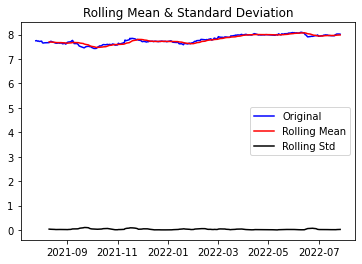

Results of Dickey-Fuller Test:
Test Statistic                  -1.088161
p-value                          0.719770
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


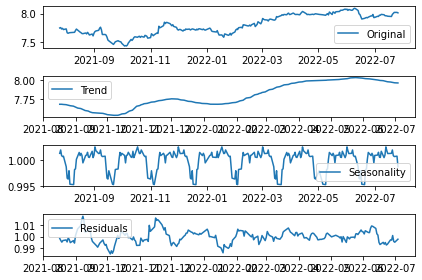

In [8]:
ts_log = nexon_ts_log

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

시계열 데이터에서 Trend와 Seasonality, 그리고 두 값을 원본 데이터에서 뺀 Residuals를 분해해 주는  seasonal_decompose 함수를 통해 시계열 데이터를 분해하였습니다. Residual에 대한 안정성을 따져봅시다.

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.756814e+00
p-value                        5.794124e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


원본 데이터였던 0.07에 비해 굉장히 안정적인 수치가 되었습니다. 

### 3.2. 학습, 테스트 데이터셋 생성

학습과 테스트 데이터셋을 9:1 비율로 나눠줍니다. 여기서 테스트 데이터셋은 가장 최근 데이터로 사용합니다.

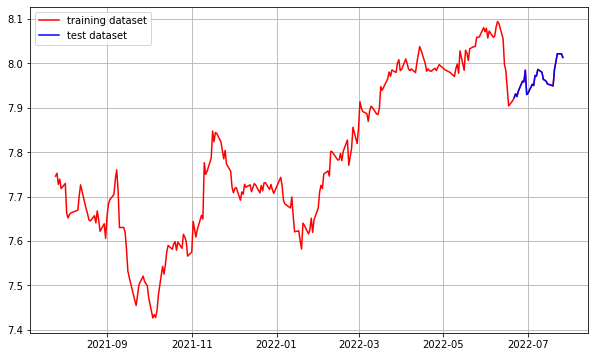

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

###3.3 적정 ARIMA 모수 찾기
이제 아리마 모델에 사용할 모수 p, q, d를 구하기 위해 몇가지를 그려볼 겁니다.  
먼저, ACF, PACF를 그려 p, q를 결정할 수 있습니다.  
ACF에서 시차q 이후에 0이 관측되고 PACF에서 시차 p 이후에 0이 관측됩니다.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


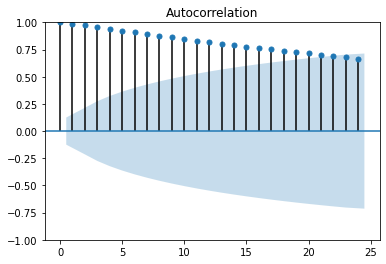

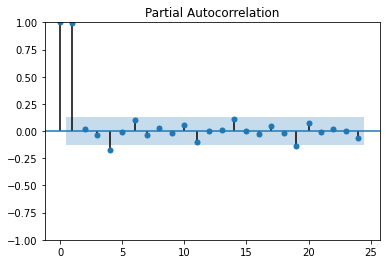

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위 그래프에서 PACF 그래프를 보면 2부터 0에 가까워짐을 알 수 있습니다. 그렇기 때문에 p를 1으로 잡고, q를 0으로 잡겠습니다. (많은 시계열 데이터가 AR이나 MA중 하나의 경향을 가지며 보통 p * q = 0이 되는 값을 사용한다.)

Results of Dickey-Fuller Test:
Test Statistic                -7.486196e+00
p-value                        4.632228e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.702658e+00
p-value                        3.772540e-14
#Lags Used                     8.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


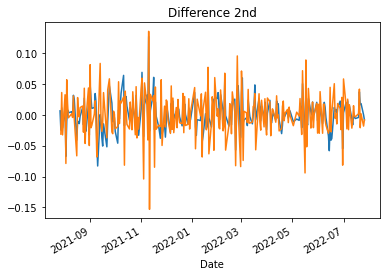

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분도 충분히 안정적이어 보이니 d는 1로 하겠습니다. 

### 3.4 ARIMA 모델 훈련가 테스트

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 486.644
Date:                Fri, 29 Jul 2022   AIC                           -969.288
Time:                        03:44:53   BIC                           -962.501
Sample:                             0   HQIC                          -966.547
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.066     -0.512      0.609      -0.162       0.095
sigma2         0.0007   4.68e-05     15.001      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


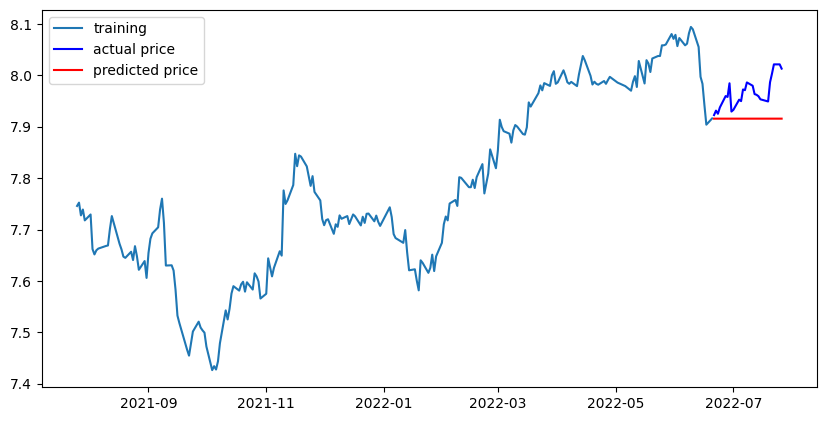

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26273.98397178954
MAE:  139.63809149480147
RMSE:  162.09251670508894
MAPE: 4.77%


예측 결과 MAPE 가 4.77%가 나왔네요

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


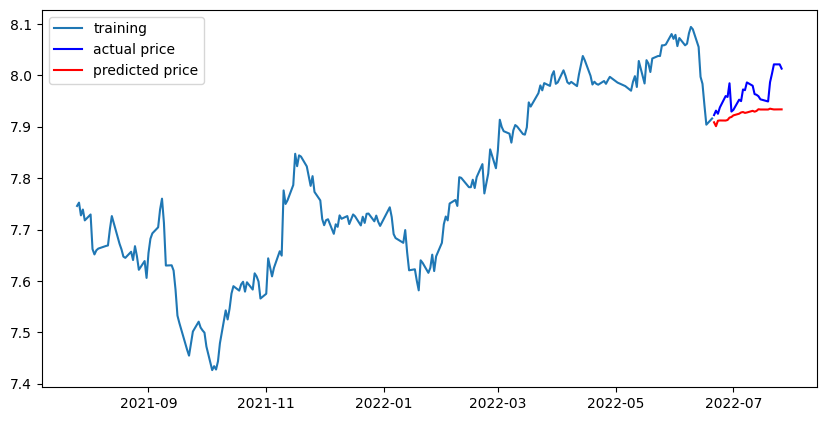

MAPE: 3.93%


In [16]:
model = ARIMA(train_data, order=(20, 1, 0))  # p, d, q
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

p를 20으로 조금 올려서 해봤는데 더 좋은 결과가 나왔네요.

## 4. 아마존 주식 분석



### 4.1 시계열 안정성 분석  

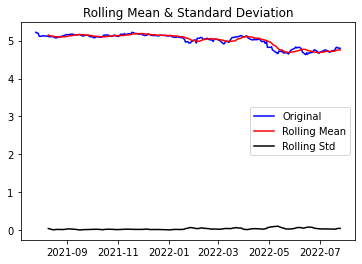

Results of Dickey-Fuller Test:
Test Statistic                  -1.254340
p-value                          0.649795
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


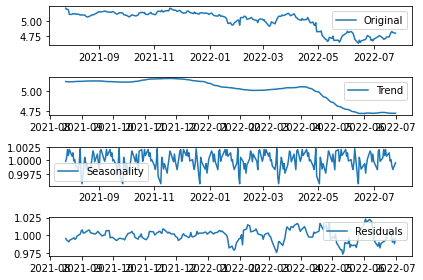

In [17]:
ts_log = amazone_ts_log

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.978272
p-value                          0.000024
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


0.000024가 나왔네요. 이전까지 보던 아주 낮은 수치는 아니지만 안정적이라고 할 수 있겠습니다.

### 4.2. 학습, 테스트 데이터셋 생성

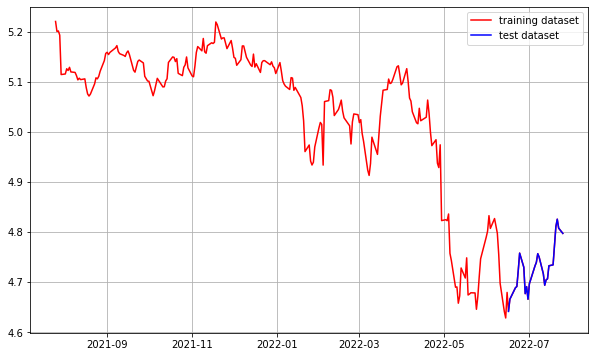

In [19]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 4.3 적정 ARIMA 모수 찾기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


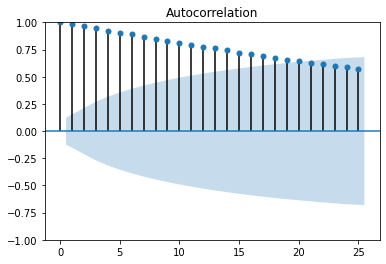

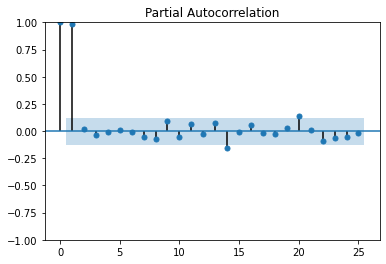

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)  
plt.show()

마찬가지로 p는 1, q는 0 으로 쓰겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.578580e+01
p-value                        1.117200e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.253575e+00
p-value                        5.310474e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


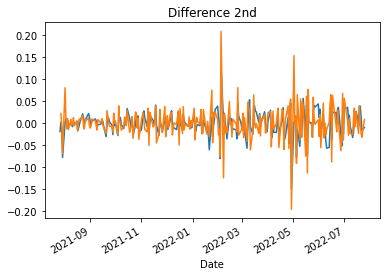

In [21]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분도 충분히 안정적이어 보이니 d는 1로 하겠습니다. 

### 4.4 ARIMA 모델 훈련과 테스트

In [22]:
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 495.330
Date:                Fri, 29 Jul 2022   AIC                           -986.659
Time:                        03:44:58   BIC                           -979.827
Sample:                             0   HQIC                          -983.902
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0090      0.062     -0.145      0.885      -0.131       0.113
sigma2         0.0007    4.3e-05     16.669      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


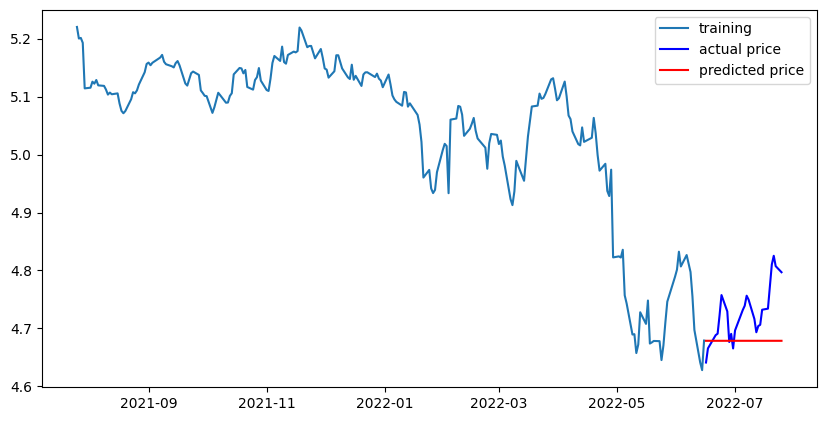

In [23]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) 
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index) 

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58.49308265064633
MAE:  5.990169951863056
RMSE:  7.648077055747172
MAPE: 5.12%


예측 결과 MAPE 가 5.12%가 나왔네요

### 4.5 P값 변경

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


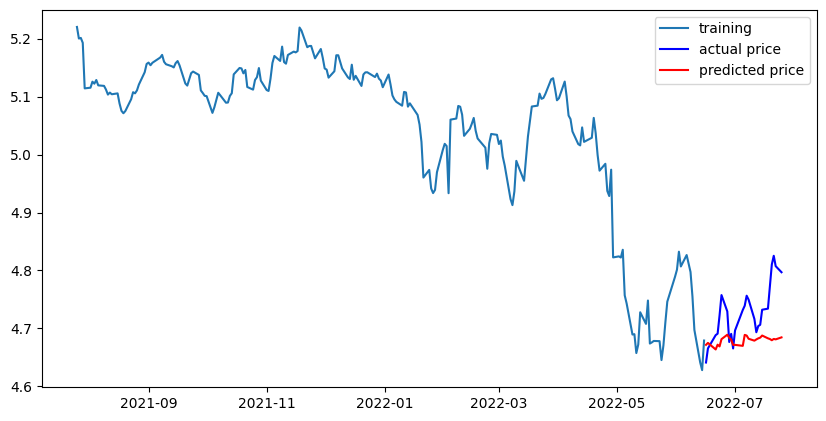

MAPE: 4.97%


In [25]:
model = ARIMA(train_data, order=(15, 1, 0))  # p, d, q
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index) 

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

p를 15로 줬더니 조금 더 낮아졌습니다.

## 5. 구글 주식 분석



### 5.1 시계열 안정성 분석  

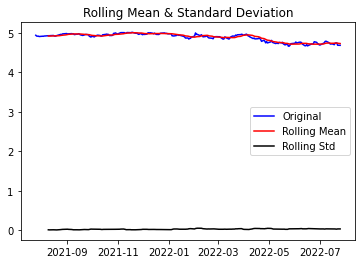

Results of Dickey-Fuller Test:
Test Statistic                  -1.004317
p-value                          0.751686
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


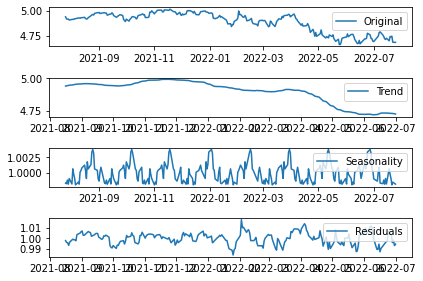

In [26]:
ts_log = google_ts_log

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.430686
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


p-value가 0.000001입니다. 안정적이죠?

### 5.2. 학습, 테스트 데이터셋 생성

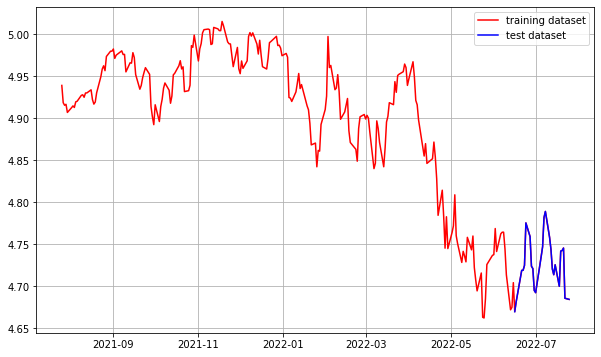

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5.3 적정 ARIMA 모수 찾기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


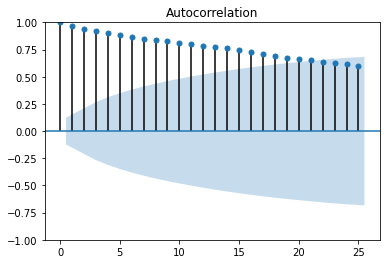

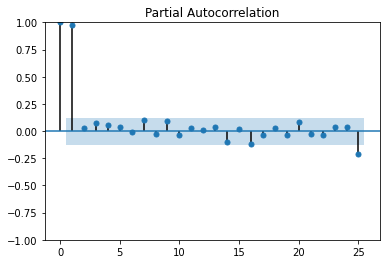

In [29]:
plot_acf(ts_log)
plot_pacf(ts_log)  
plt.show()

마찬가지로 p는 1, q는 0 으로 쓰겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.651157e+01
p-value                        2.103582e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.439653e+00
p-value                        4.933960e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


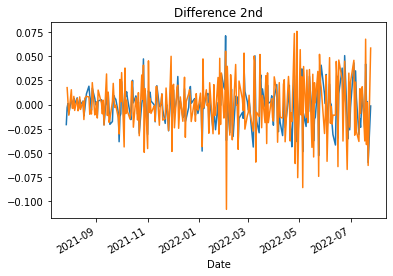

In [30]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분도 충분히 안정적이어 보이니 d는 1로 하겠습니다. 

### 5.4 ARIMA 모델 훈련과 테스트

In [31]:
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 571.040
Date:                Fri, 29 Jul 2022   AIC                          -1138.080
Time:                        03:45:02   BIC                          -1131.248
Sample:                             0   HQIC                         -1135.323
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0477      0.061     -0.781      0.435      -0.167       0.072
sigma2         0.0004   2.94e-05     12.411      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


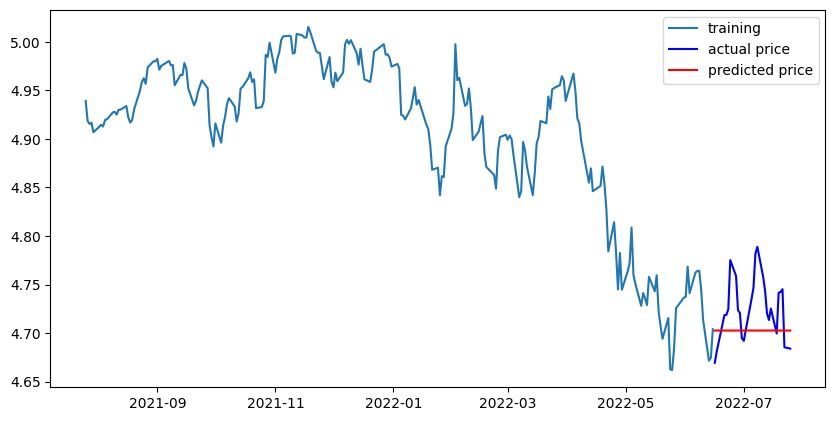

In [32]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) 
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index) 

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  19.720206976089358
MAE:  3.6564144615295158
RMSE:  4.440743966509368
MAPE: 3.18%


예측 결과 MAPE 가 3.18%가 나왔네요

### 5.5 P값 변경

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


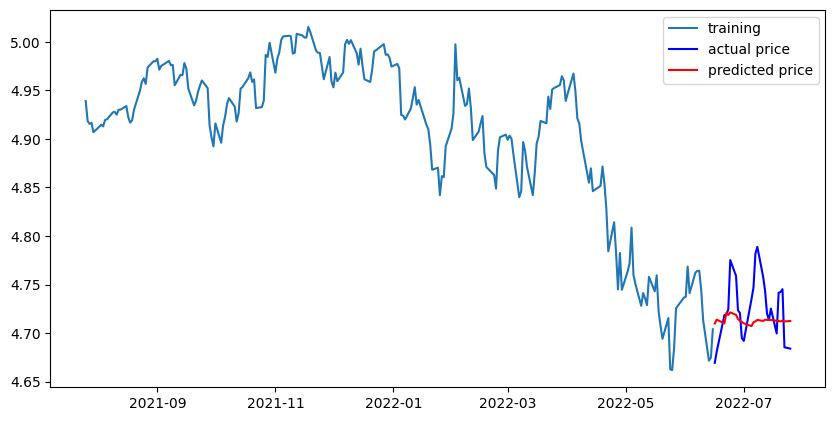

MAPE: 2.65%


In [34]:
model = ARIMA(train_data, order=(15, 1, 0))  # p, d, q
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index) 

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

p를 15로 줬더니 조금 더 낮아졌습니다.

##6 회고
- ACF, PACF를 참고해서 p와 q를 설정하는데 내가 테스트한 주식 데이터만 그런건진 모르겠는데 그래프만 봐서는 세 주식데이터 모두 p를 1로 설정하도록 되어있었다. 근데 p를 1로 설정하니 예측그래프에서 직선만 딸랑 나와서 이게 맞는건가 싶었다. 노드처럼 p를 15~20정도로 늘려주니까 그래도 뭔가 변화가 되긴 하던데 제대로 예측이 되는건지 모르겠다.
- 그래도 MAPE점수는 낮게 나와서 다행인가 싶기도 한데.. 뭔가 아쉬운 결과다..
- 야후에 내가 관심있는 종목이 없었어서 조금 아쉬웠다. 다른 데이터를 구할 수 있는 방법도 찾아봐야 겠다.
